### Workbook for calculating journey distances for Rwanda catchment survey respondents
Week of July 7, 2025
<br>
Author: Adele Birkenes

In [28]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import os
import matplotlib.pyplot as plt
import numpy as np

Task 1: Read in Rwanda bridge sites (df), catchment survey data (df), and village boundaries (gdf)

In [29]:
synced_catchment_path = "../../synced-data/catchment-analysis"
synced_population_path = "../../synced-data/population-exploration"
graphics_path = "../../notebooks/catchment-analysis/graphics"

# Rwanda bridge sites
Rwanda_bridges_fp = os.path.join(synced_catchment_path, "Rwanda_catchment_bridge_sites.csv")
Rwanda_bridges = pd.read_csv(Rwanda_bridges_fp, encoding='ISO-8859-1') # Note: This encoding accommodates special characters)

# Rwanda catchment survey data
Rwanda_catchment_surveys_fp = os.path.join(synced_catchment_path, "Rwanda_catchment_all_surveys.csv")
Rwanda_catchment_surveys = pd.read_csv(Rwanda_catchment_surveys_fp, encoding='ISO-8859-1')

# Rwanda village boundaries
Rwanda_village_boundaries_fp = os.path.join(synced_population_path, "Rwanda Village Boundaries/Village.shp")
Rwanda_village_boundaries = gpd.read_file(Rwanda_village_boundaries_fp, encoding='ISO-8859-1')

In [30]:
# Minimal data cleaning - ensure that destination admin codes in catchment survey data do not have decimal points
Rwanda_catchment_surveys['Destination - Admin Code'] = Rwanda_catchment_surveys['Destination - Admin Code'].astype(str).str.replace('.0', '', regex=False)

Task 2: Convert bridge sites dataframe to geodataframe that has custom Rwanda TM CRS copied from village boundaries geodataframe

In [31]:
# Convert bridge sites dataframe to geodataframe that has custom Rwanda TM CRS copied from village boundaries geodataframe
def map_bridges(bridges, bridges_lat, bridges_lon, village_boundaries):

    # Check CRS of village boundaries gdf
    print(f'The CRS of the village boundaries gdf is: {village_boundaries.crs}')

    # Create lat/lon variables
    lon = bridges[bridges_lon]
    lat = bridges[bridges_lat]

    # Create gdf of bridges data by converting lat/lon values to list of Shapely Point objects
    bridge_points = gpd.GeoDataFrame(bridges, geometry=gpd.points_from_xy(x=lon, y=lat), crs='EPSG:4326')

    # Set CRS of bridges gdf to CRS of village boundaries gdf
    bridge_points.to_crs(village_boundaries.crs, inplace=True)

    # Check that reprojection was successful
    print(f'The CRS of the bridges gdf is: {bridge_points.crs}')
    
    return bridge_points

bridge_points = map_bridges(bridges = Rwanda_bridges,
                            bridges_lat = "Lat",
                            bridges_lon = "Long",
                            village_boundaries = Rwanda_village_boundaries)

The CRS of the village boundaries gdf is: PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",500000],PARAMETER["false_northing",5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
The CRS of the bridges gdf is: PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_

Task 3: Calculate & assign centroids to all polygons in village boundaries geodataframe

In [32]:
# Calculate the centroid of each village polygon
def calculate_village_centroids(village_gdf):
    village_gdf['centroid'] = village_gdf.geometry.centroid
    return village_gdf

# Apply the function to calculate centroids
village_centroids = calculate_village_centroids(village_gdf = Rwanda_village_boundaries)

# Print the first few rows of one of the centroids geodataframes to verify
print(village_centroids.head())

     District Village_ID Cell_ID Sector_ID Distr_ID Prov_ID        Name  \
0  Nyarugenge   11010102  110101      1101       11       1     Gihanga   
1  Nyarugenge   11010103  110101      1101       11       1  Iterambere   
2  Nyarugenge   11010104  110101      1101       11       1       Izuba   
3  Nyarugenge   11010105  110101      1101       11       1  Nyaburanga   
4  Nyarugenge   11010106  110101      1101       11       1    Nyenyeri   

        Cell  Sector                      Province  \
0  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
1  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
2  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
3  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
4  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   

                                            geometry  \
0  POLYGON Z ((505804.107 4784697.395 0, 505808.8...   
1  POLYGON Z ((505725.35 4785070.964 0, 505750.76...   
2  POLYGON Z ((505689.339 4785047.225 0, 505712.2...   


Task 4: Assign centroids to each catchment survey response by matching the admin codes from the catchment survey data to the admin codes in the village boundaries geodataframe

In [33]:
# Assign centroids for home villages to catchment survey data
def assign_home_village_centroids(survey_data, village_centroids):
    
    # Ensure both columns are of the same type before merging
    survey_data['Home Village - Admin Code'] = survey_data['Home Village - Admin Code'].astype(str)
    village_centroids['Village_ID'] = village_centroids['Village_ID'].astype(str)

    # Join centroids to survey data using shared admin codes; store centroids in a new column
    survey_data = survey_data.merge(village_centroids[['Village_ID', 'centroid']],
                                    left_on='Home Village - Admin Code',
                                    right_on='Village_ID',
                                    how='left')

    # Rename centroid column
    survey_data.rename(columns={'centroid': 'home_centroid'}, inplace=True)

    return survey_data

# Apply the function
Rwanda_catchment_surveys = assign_home_village_centroids(survey_data = Rwanda_catchment_surveys, village_centroids = village_centroids)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

In [34]:
# Assign centroids for destination villages to catchment survey data
def assign_destination_village_centroids(survey_data, village_centroids):

    # Ensure both columns are of the same type before merging
    survey_data['Destination - Admin Code'] = survey_data['Destination - Admin Code'].astype(str)
    village_centroids['Village_ID'] = village_centroids['Village_ID'].astype(str)

    # Join centroids to survey data using shared admin codes; store centroids in a new column
    survey_data = survey_data.merge(village_centroids[['Village_ID', 'centroid']],
                                    left_on='Destination - Admin Code',
                                    right_on='Village_ID',
                                    how='left')

    # Rename centroid column
    survey_data.rename(columns={'centroid': 'destination_centroid'}, inplace=True)

    return survey_data

# Apply the function
Rwanda_catchment_surveys = assign_destination_village_centroids(survey_data = Rwanda_catchment_surveys, village_centroids = village_centroids)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

Task 5: Assign bridge coordinates to catchment survey responses

In [35]:
# Assign bridge coordinates to catchment survey data
def assign_bridge_coordinates(survey_data, bridge_points):

    # Ensure both columns are of the same type before merging
    survey_data['Bridge Site'] = survey_data['Bridge Site'].astype(str)
    bridge_points['Bridge Name'] = bridge_points['Bridge Name'].astype(str)

    # Join bridge coordinates to survey data using shared bridge names
    survey_data = survey_data.merge(bridge_points[['Bridge Name', 'geometry']],
                                    left_on='Bridge Site',
                                    right_on='Bridge Name',
                                    how='left')

    # Rename coordinates column
    survey_data.rename(columns={'geometry': 'bridge_coordinates'}, inplace=True)

    return survey_data

# Apply the function
Rwanda_catchment_surveys = assign_bridge_coordinates(survey_data = Rwanda_catchment_surveys, bridge_points = bridge_points)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

Task 6: Calculate Euclidean distance between home/destination centroids and bridge sites for each catchment survey response. Calculate home and destination distances separately and then sum for total distance

In [36]:
# Calculate journey distances for survey respondents
def calculate_journey_distances(survey_data):

    # Calculate distance from home village centroid to bridge coordinates
    survey_data['home_to_bridge_distance'] = survey_data.apply(
        lambda row: row['home_centroid'].distance(row['bridge_coordinates'])
        if row['home_centroid'] is not None and row['bridge_coordinates'] is not None
        else np.nan, axis=1)

    # Calculate distance from bridge coordinates to destination village centroid
    survey_data['bridge_to_destination_distance'] = survey_data.apply(
        lambda row: row['bridge_coordinates'].distance(row['destination_centroid'])
        if row['bridge_coordinates'] is not None and row['destination_centroid'] is not None
        else np.nan, axis=1)

    survey_data['total_distance'] = survey_data['home_to_bridge_distance'] + survey_data['bridge_to_destination_distance']

    return survey_data

# Apply the function
Rwanda_catchment_surveys = calculate_journey_distances(survey_data = Rwanda_catchment_surveys)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

Task 7: Explore journey distance distribution and outliers

In [37]:
def calculate_summary_stats(survey_data):
    stats = survey_data.groupby('Bridge Site')['total_distance'].agg(['mean', 'median', 'std', 'count'])
    null_counts = survey_data.groupby('Bridge Site')['total_distance'].apply(lambda x: x.isnull().sum())
    stats['null_count'] = null_counts
    stats['total_count'] = survey_data.groupby('Bridge Site')['total_distance'].count()
    stats = stats.reset_index()
    return stats

# Apply the function
average_distances = calculate_summary_stats(survey_data=Rwanda_catchment_surveys)

print(average_distances)

         Bridge Site          mean        median           std  count  \
0           Gahororo   2911.360582   2843.055711   2511.505711    987   
1             Gasasa   8841.029146   9919.912851   6815.863389    537   
2          Kanyarira  14346.070588   7771.700704  19468.160175    471   
3            Muhembe  14626.028068  15362.665259   8289.021280    256   
4           Muregeya   8514.903048   5474.920851  11121.032887    327   
5        Mutiwingoma   5186.731435   4211.072164   4976.175342    270   
6         Nyarusange  29119.650855  11309.191881  36688.690965     43   
7            Rugeshi  22960.340480  27545.171504   8719.391530    890   
8           Ruharazi   2694.966454   1560.090295   2449.553082    236   
9          Rwamamara   4678.358303   2919.849307   8441.834352    612   
10          Rwimvubu   5576.463964   3676.110199   6437.381072    472   
11  Uwumugeti-Kigusa   2373.613822   1783.078685   2686.030622    258   

    null_count  total_count  
0            0      

In [38]:
# Use describe to generate min, max, and quartiles to help ID outlier responses
def describe_bridge_distances(survey_data):
    return survey_data.groupby('Bridge Site')['total_distance'].describe().reset_index()

# Apply the function
summary_stats = describe_bridge_distances(survey_data = Rwanda_catchment_surveys)

# Print the summary statistics
print(summary_stats)

         Bridge Site  count          mean           std          min  \
0           Gahororo  987.0   2911.360582   2511.505711  1379.431138   
1             Gasasa  537.0   8841.029146   6815.863389  1585.189209   
2          Kanyarira  471.0  14346.070588  19468.160175  1850.814443   
3            Muhembe  256.0  14626.028068   8289.021280  1491.030563   
4           Muregeya  327.0   8514.903048  11121.032887  1506.857719   
5        Mutiwingoma  270.0   5186.731435   4976.175342  1459.025138   
6         Nyarusange   43.0  29119.650855  36688.690965  1121.851569   
7            Rugeshi  890.0  22960.340480   8719.391530  1458.993792   
8           Ruharazi  236.0   2694.966454   2449.553082   996.976442   
9          Rwamamara  612.0   4678.358303   8441.834352  1414.972713   
10          Rwimvubu  472.0   5576.463964   6437.381072  1558.403479   
11  Uwumugeti-Kigusa  258.0   2373.613822   2686.030622  1442.521286   

             25%           50%           75%           max  
0 

<Figure size 1200x600 with 0 Axes>

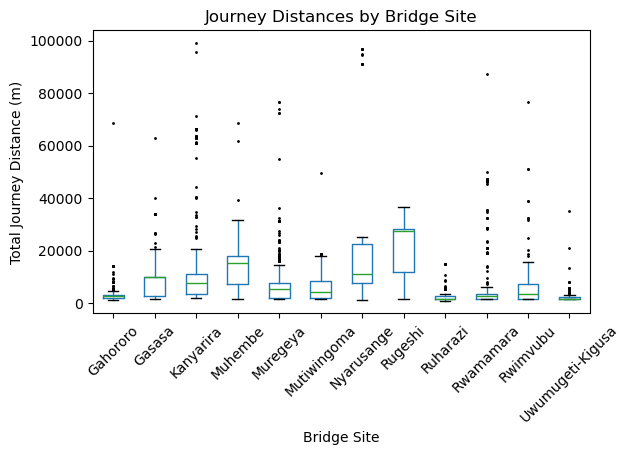

In [124]:
# Create boxplot of journey distances by bridge site
def plot_journey_distances_boxplot(survey_data):
    plt.figure(figsize=(12, 6))
    survey_data.boxplot(column='total_distance', by='Bridge Site', grid=False, 
                        flierprops={'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 1})
    plt.title('Journey Distances by Bridge Site')
    plt.suptitle('')
    plt.xlabel('Bridge Site')
    plt.ylabel('Total Journey Distance (m)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Apply the function
plot_journey_distances_boxplot(survey_data = Rwanda_catchment_surveys)

In [40]:
# def remove_outliers_iqr_per_bridge(survey_data):
#     filtered_indices = []
#     outliers_count = []

#     for bridge, group in survey_data.groupby('Bridge Site'):
#         Q1 = group['total_distance'].quantile(0.25)
#         Q3 = group['total_distance'].quantile(0.75)
#         IQR = Q3 - Q1
#         #lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 3 * IQR

#         # mask = (group['total_distance'] >= lower_bound) & (group['total_distance'] <= upper_bound)mask = (group['total_distance'] >= lower_bound) & (group['total_distance'] <= upper_bound)
#         mask = group['total_distance'] <= upper_bound
#         filtered_indices.extend(group[mask].index)
#         outliers_count.append({'Bridge Site': bridge, 
#                                'outliers_count': (~mask).sum(), 
#                                'non_outliers_count': mask.sum(), 
#                                'total_count': len(group),
#                                'percent_outliers': (~mask).sum() / len(group) * 100})

#     filtered_data = survey_data.loc[filtered_indices]
#     outliers_count_df = pd.DataFrame(outliers_count)
#     return filtered_data, outliers_count_df

# # Apply the function
# filtered_data, outliers_count = remove_outliers_iqr_per_bridge(survey_data=Rwanda_catchment_surveys)
# print(outliers_count)

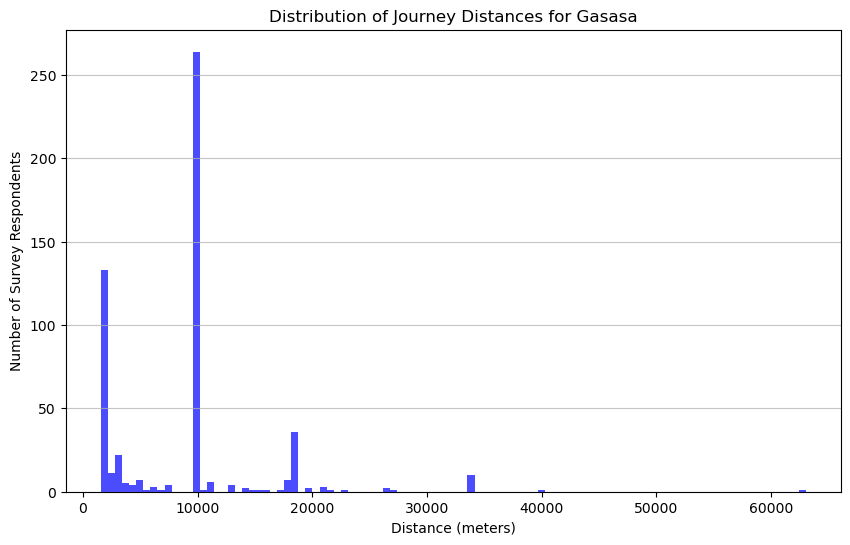

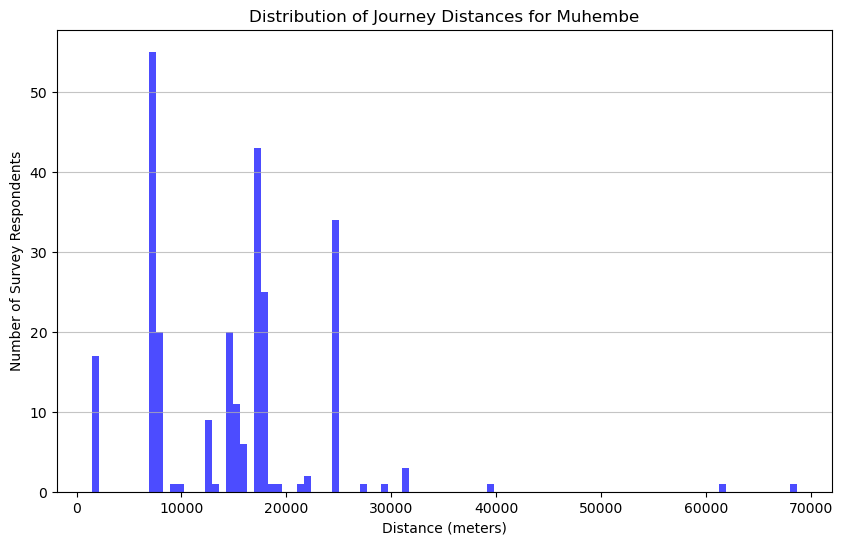

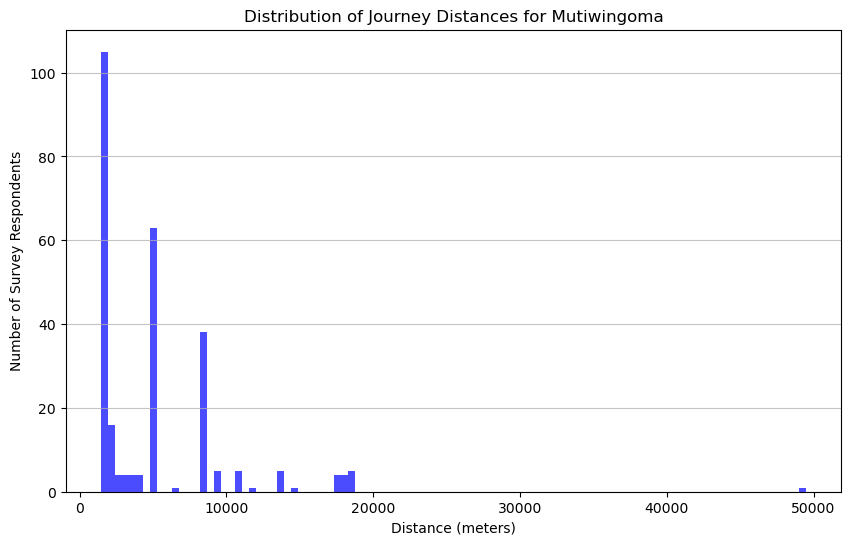

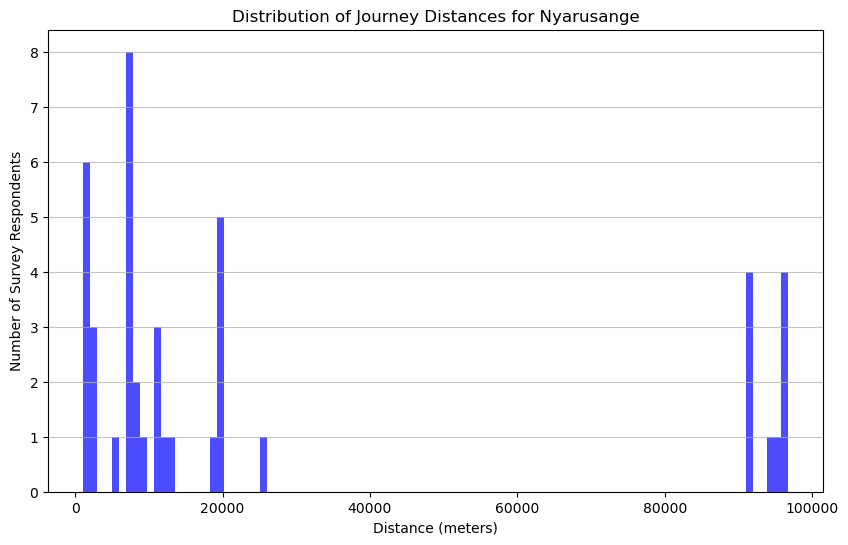

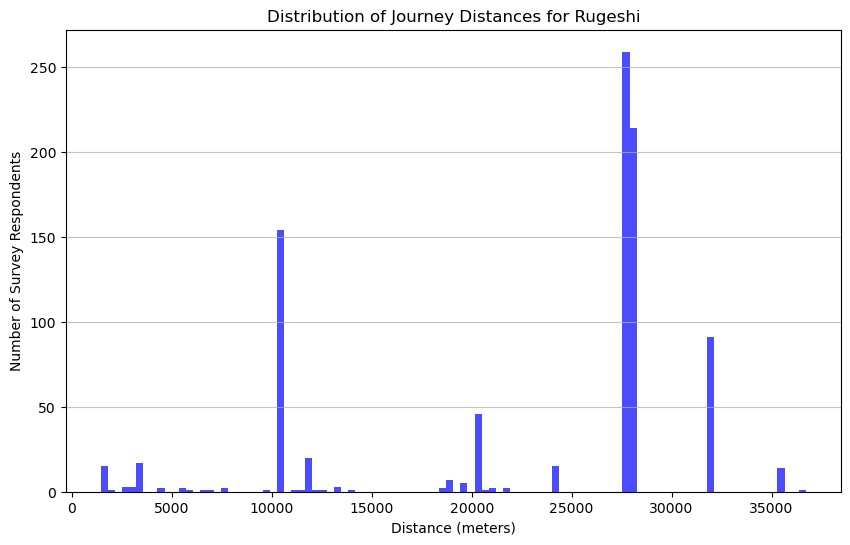

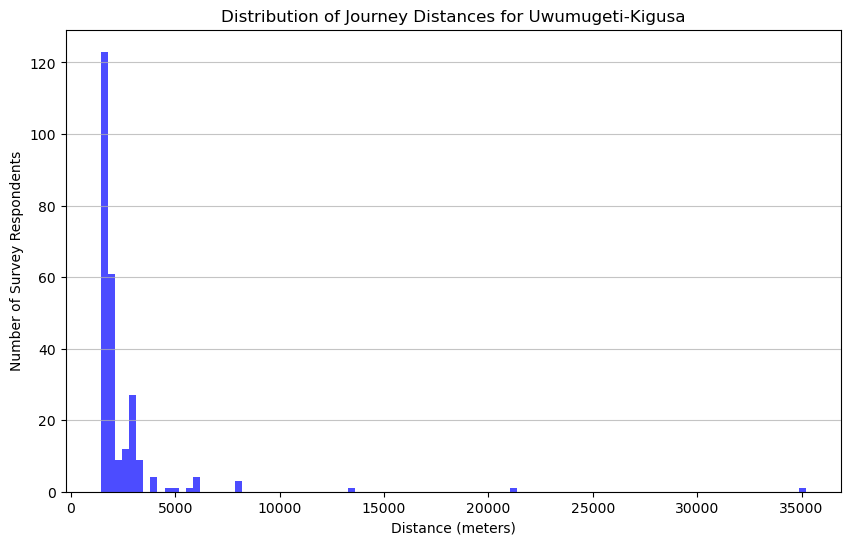

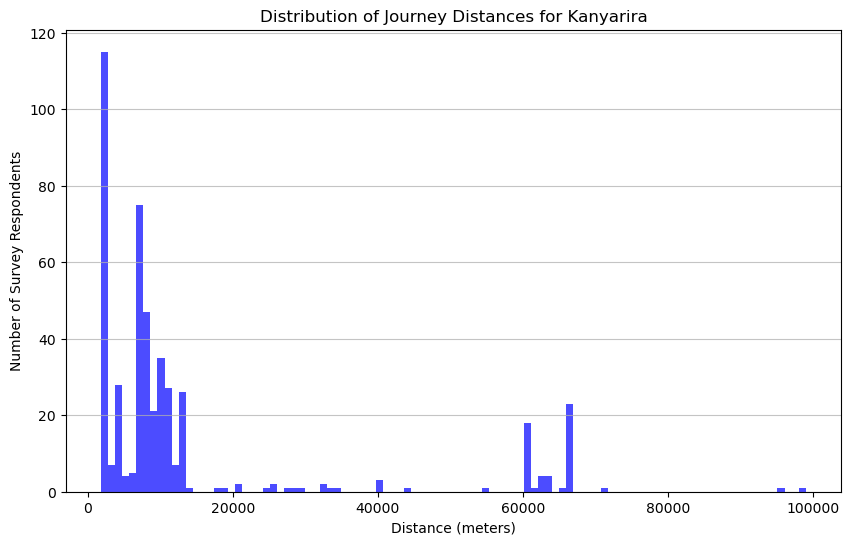

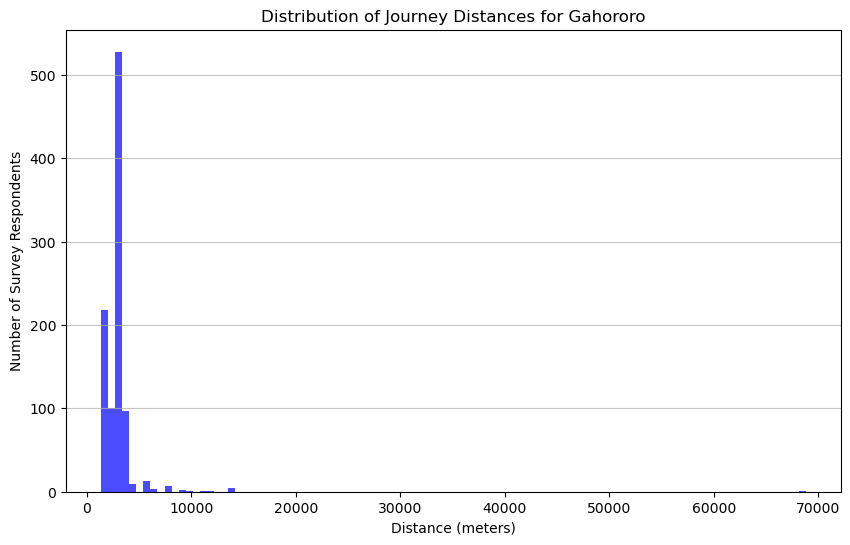

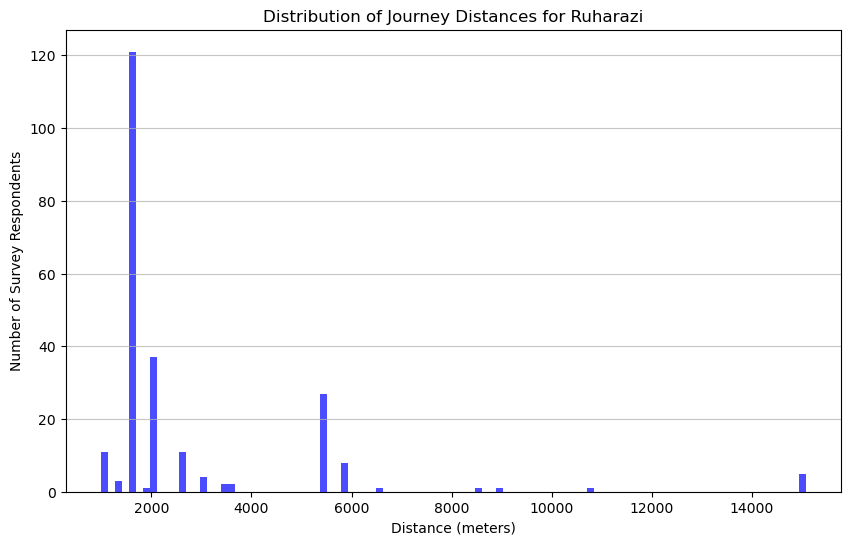

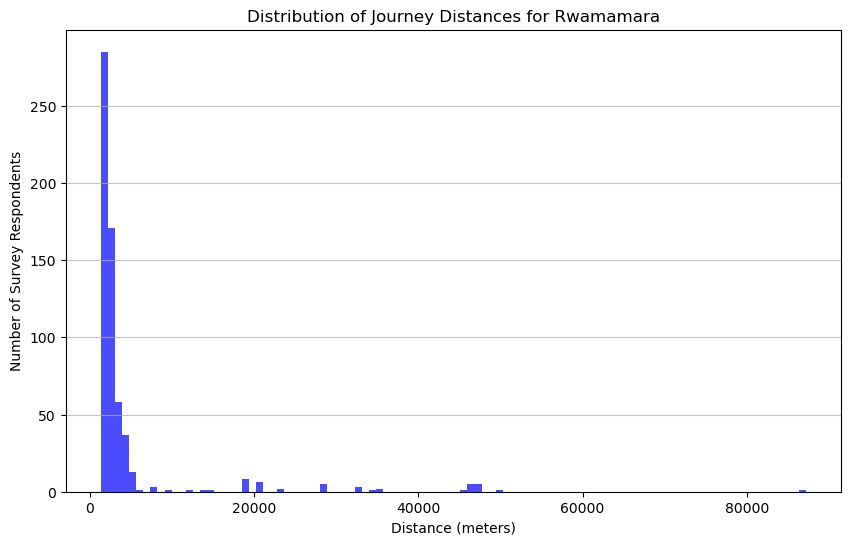

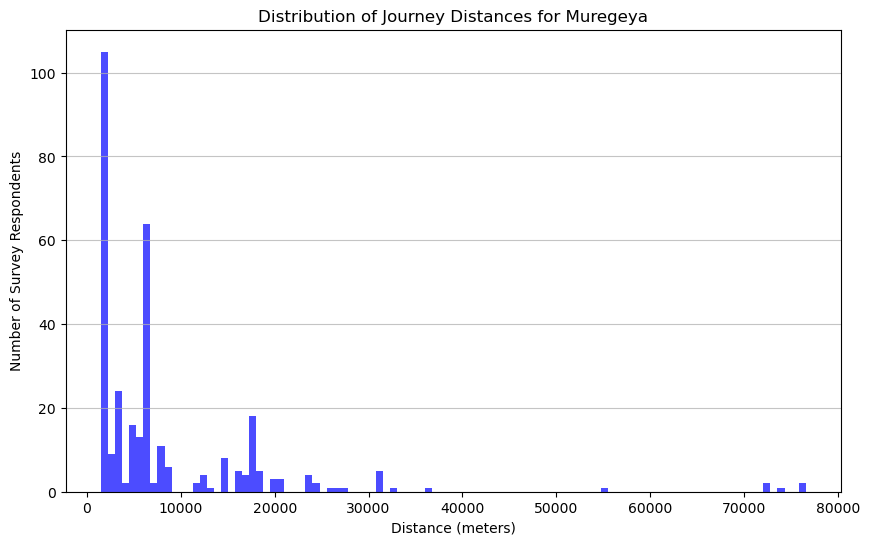

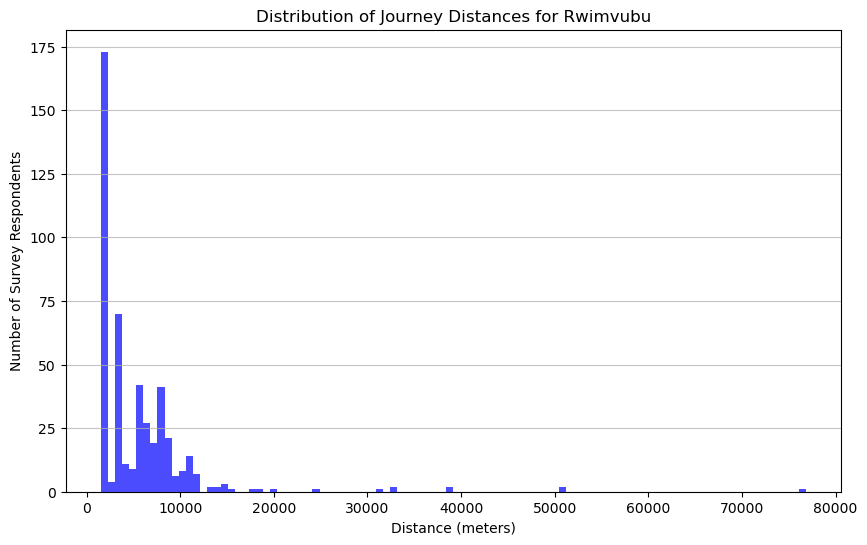

In [41]:
# Create distribution plots of journey distances for each bridge site
def plot_journey_distance_distribution(survey_data, bridge_sites):
    for bridge in bridge_sites:
        plt.figure(figsize=(10, 6))
        subset = survey_data[survey_data['Bridge Site'] == bridge]
        plt.hist(subset['total_distance'].dropna(), bins=100, alpha=0.7, color='blue')
        plt.title(f'Distribution of Journey Distances for {bridge}')
        plt.xlabel('Distance (meters)')
        plt.ylabel('Number of Survey Respondents')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

# Apply the plotting function
plot_journey_distance_distribution(survey_data = Rwanda_catchment_surveys, bridge_sites = Rwanda_catchment_surveys['Bridge Site'].unique())

Task 8: Explore the relationship between journey distance and survey response variables: Purpose of Travel - Categorized, Travel time, Gender, Approximate Age, Mode of Transportation

In [117]:
def calculate_average_distances_by_column(survey_data, column_name, color):
    if column_name not in survey_data.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the survey data.")

    mean_distance = survey_data.groupby(column_name)['total_distance'].mean().reset_index()
    mean_distance = mean_distance.sort_values('total_distance', ascending=False)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_distance[column_name], mean_distance['total_distance'], color=color)
    plt.title(f"Average Journey Distance by {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Average Journey Distance (m)")
    plt.xticks(rotation=45)
    plt.show()

    return mean_distance

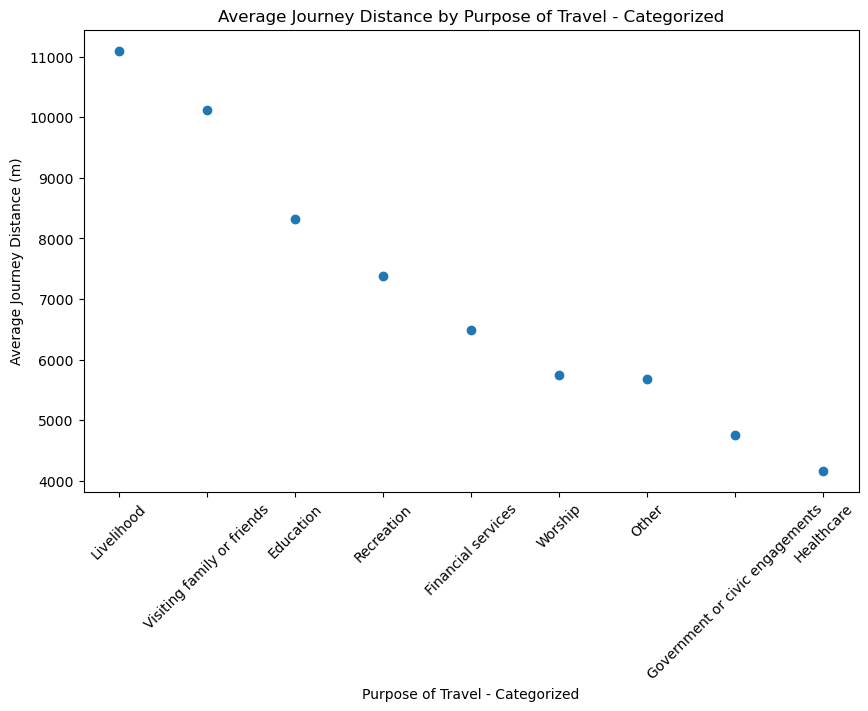

,Purpose of Travel - Categorized,total_distance
4,Livelihood,11098.701612
7,Visiting family or friends,10113.499530
0,Education,8324.138293
6,Recreation,7381.618380
1,Financial services,6494.414690
8,Worship,5749.795963
5,Other,5675.846231
2,Government or civic engagements,4751.201048
3,Healthcare,4167.159124


In [ ]:
# Combine "Other" and "Others" categories into a single category
Rwanda_catchment_surveys['Purpose of Travel - Categorized'] = (
    Rwanda_catchment_surveys['Purpose of Travel - Categorized'].str.strip().replace({'Others': 'Other'})
)

calculate_average_distances_by_column(Rwanda_catchment_surveys, 'Purpose of Travel - Categorized',  color='blue')

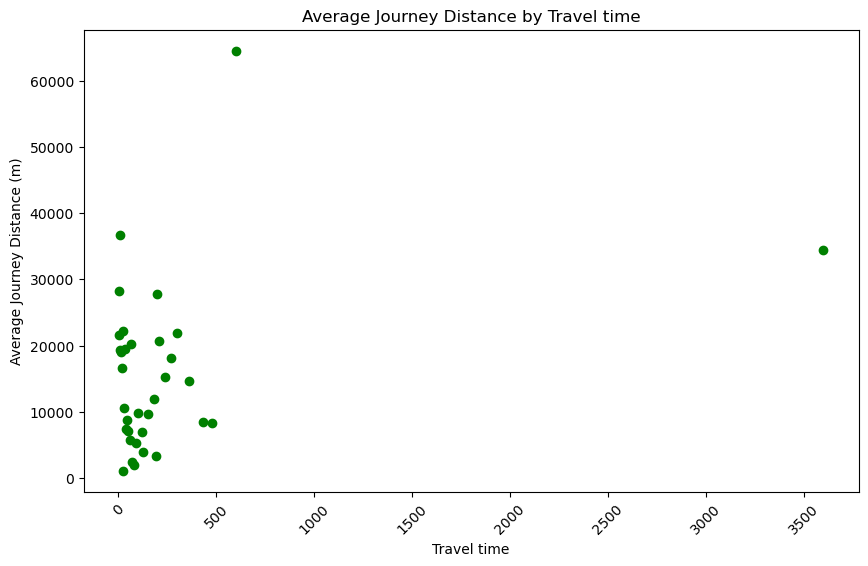

,Travel time,total_distance
41,600.0,64496.380165
2,7.0,36708.565228
42,3600.0,34408.899067
1,5.0,28234.039449
28,200.0,27780.880040
7,25.0,22173.815616
33,300.0,21921.830318
0,3.0,21605.752809
29,210.0,20645.500881
15,65.0,20207.799305


In [118]:
calculate_average_distances_by_column(Rwanda_catchment_surveys, 'Travel time', color='green')

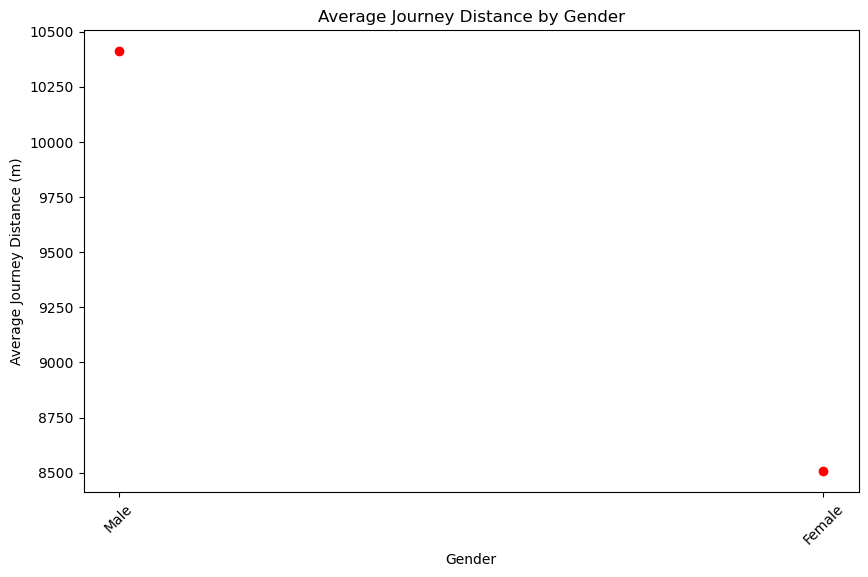

,Gender,total_distance
1,Male,10411.420675
0,Female,8506.417477


In [121]:
calculate_average_distances_by_column(Rwanda_catchment_surveys, 'Gender', color='red')

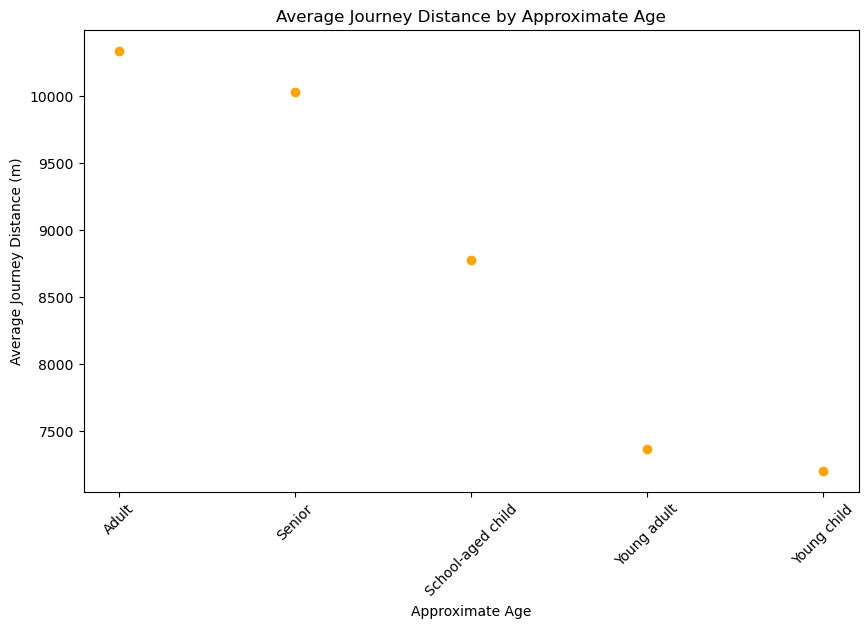

,Approximate Age,total_distance
0,Adult,10335.582248
2,Senior,10027.056935
1,School-aged child,8774.474322
3,Young adult,7366.850552
4,Young child,7202.986694


In [119]:
calculate_average_distances_by_column(Rwanda_catchment_surveys, 'Approximate Age', color='orange')

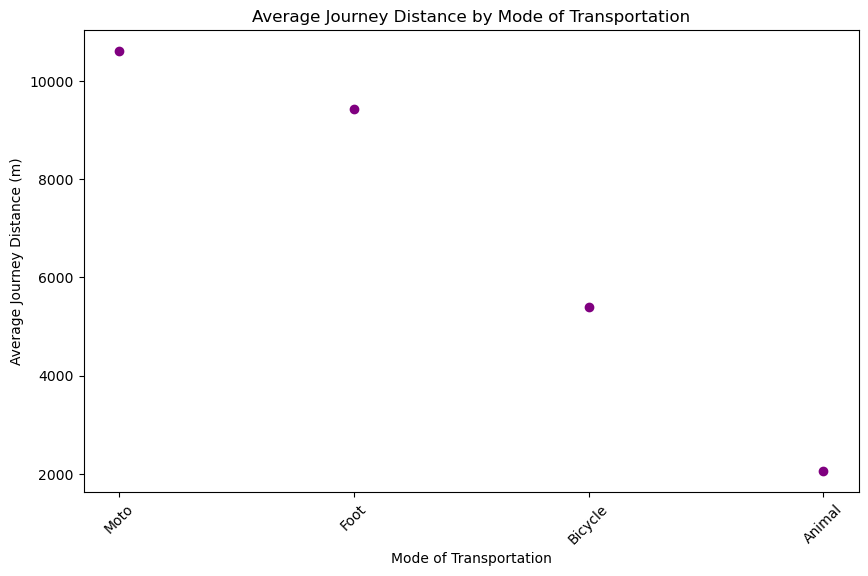

,Mode of Transportation,total_distance
3,Moto,10609.253731
2,Foot,9432.381751
1,Bicycle,5393.935248
0,Animal,2058.885276


In [120]:
calculate_average_distances_by_column(Rwanda_catchment_surveys, 'Mode of Transportation', color='purple')

In [91]:
# Investigate whether the difference in journey distance for men and women is statistically significant
# Use a t-test to compare the means of two independent samples

from scipy import stats

def t_test_gender(survey_data):
    men_distances = survey_data[survey_data['Gender'] == 'Male']['total_distance'].dropna()
    women_distances = survey_data[survey_data['Gender'] == 'Female']['total_distance'].dropna()

    t_stat, p_value = stats.ttest_ind(men_distances, women_distances, equal_var=False)

    print(f"T-test results for journey distance by gender:")
    print(f"t_stat: {t_stat}")
    print(f"p_value: {p_value}")
    if p_value < 0.05:
        print("The difference in journey distance between men and women is statistically significant.")
    else:
        print("The difference in journey distance between men and women is not statistically significant.")

    return t_stat, p_value

t_test_gender_result = t_test_gender(Rwanda_catchment_surveys)

T-test results for journey distance by gender:
t_stat: 5.90006434361857
p_value: 3.85731167334945e-09
The difference in journey distance between men and women is statistically significant.


In [93]:
# Investigate whether the difference in journey distance for other response variables with more than two categories is statistically significant
# Use ANOVA (Analysis of Variance) for this

def anova_test(survey_data, column_name):
    if column_name not in survey_data.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the survey data.")

    groups = [group['total_distance'].dropna() for name, group in survey_data.groupby(column_name)]
    f_stat, p_value = stats.f_oneway(*groups)

    print(f"ANOVA results for journey distance by {column_name}:")
    print(f"f_stat: {f_stat}")
    print(f"p_value: {p_value}")
    if p_value < 0.05:
        print(f"At least one category of {column_name} has a statistically significant difference in journey distance.")
    else:
        print(f"The difference in journey distance between categories of {column_name} is not statistically significant.")

    return f_stat, p_value

In [102]:
# Run ANOVA for 'Purpose of Travel - Categorized'
anova_test(Rwanda_catchment_surveys, 'Purpose of Travel - Categorized')

ANOVA results for journey distance by Purpose of Travel - Categorized:
f_stat: 24.037290443109814
p_value: 1.3036256081568553e-36
At least one category of Purpose of Travel - Categorized has a statistically significant difference in journey distance.


(np.float64(24.037290443109814), np.float64(1.3036256081568553e-36))

In [94]:
# Run ANOVA for 'Approximate Age'
anova_test(Rwanda_catchment_surveys, 'Approximate Age')

ANOVA results for journey distance by Approximate Age:
f_stat: 11.257488138199005
p_value: 4.272878363116363e-09
At least one category of Approximate Age has a statistically significant difference in journey distance.


(np.float64(11.257488138199005), np.float64(4.272878363116363e-09))

In [95]:
# Run ANOVA for 'Mode of Transportation'
anova_test(Rwanda_catchment_surveys, 'Mode of Transportation')

ANOVA results for journey distance by Mode of Transportation:
f_stat: 1.056973030774756
p_value: 0.3661103912120681
The difference in journey distance between categories of Mode of Transportation is not statistically significant.


(np.float64(1.056973030774756), np.float64(0.3661103912120681))

In [104]:
# Given that at least one category of Purpose of Travel and Approximate Age has a statistically significant difference,
# Explore post-hoc statistical tests for determining which groups significantly differ from each other

# The Tukey's Honestly Significant Difference (HSD) Test is the most widely used post-hoc test
# However, it is most suitable when group sizes are equal or nearly equal
# Is this the case for Purpose of Travel and Approximate Age?

# Get count of survey responses per unique value in Purpose of Travel
purpose_counts = Rwanda_catchment_surveys['Purpose of Travel - Categorized'].value_counts(dropna=True)
print(purpose_counts)

# Get count of survey responses per unique value in Approximate Age
age_counts = Rwanda_catchment_surveys['Approximate Age'].value_counts(dropna=True)
print(f"\n{age_counts}")

# The group sizes are not equal
# Therefore, pair-wise t-tests with the Bonferroni Correction will be used


Purpose of Travel - Categorized
Livelihood                         3788
Education                          1130
Visiting family or friends          996
Worship                             690
Recreation                          373
Healthcare                          265
Government or civic engagements      96
Financial services                   81
Other                                51
Name: count, dtype: int64

Approximate Age
Adult                3711
School-aged child    2160
Young adult          1006
Senior                558
Young child            13
Name: count, dtype: int64


In [107]:
# Perform pairwise t-tests between all groups in 'Purpose of Travel - Categorized' and apply Bonferroni correction
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Get unique groups
groups = Rwanda_catchment_surveys['Purpose of Travel - Categorized'].dropna().unique()

# Prepare lists to store results
p_values = []
comparisons = []

# Perform pairwise t-tests
for g1, g2 in combinations(groups, 2):
    data1 = Rwanda_catchment_surveys[Rwanda_catchment_surveys['Purpose of Travel - Categorized'] == g1]['total_distance'].dropna()
    data2 = Rwanda_catchment_surveys[Rwanda_catchment_surveys['Purpose of Travel - Categorized'] == g2]['total_distance'].dropna()
    stat, p = ttest_ind(data1, data2, equal_var=False)
    p_values.append(p)
    comparisons.append(f"{g1} vs {g2}")

# Apply Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print pairs for which the difference is statistically significant, including p-values
print("Statistically significant pairs (Bonferroni corrected):")
for comp, pval_corr in zip(comparisons, pvals_corrected):
    if pval_corr < 0.05:
        print(f"{comp}: Bonferroni corrected p-value={pval_corr:.4g}")

Statistically significant pairs (Bonferroni corrected):
Livelihood vs Education: Bonferroni corrected p-value=1.421e-08
Livelihood vs Recreation: Bonferroni corrected p-value=0.0003053
Livelihood vs Worship: Bonferroni corrected p-value=2.523e-33
Livelihood vs Financial services: Bonferroni corrected p-value=0.0003538
Livelihood vs Government or civic engagements: Bonferroni corrected p-value=3.933e-19
Livelihood vs Healthcare: Bonferroni corrected p-value=3.183e-48
Education vs Worship: Bonferroni corrected p-value=1.287e-05
Education vs Government or civic engagements: Bonferroni corrected p-value=1.705e-06
Education vs Healthcare: Bonferroni corrected p-value=2.341e-14
Recreation vs Healthcare: Bonferroni corrected p-value=0.007125
Visiting family or friends vs Worship: Bonferroni corrected p-value=4.99e-11
Visiting family or friends vs Financial services: Bonferroni corrected p-value=0.03595
Visiting family or friends vs Government or civic engagements: Bonferroni corrected p-value

In [108]:
# Perform pairwise t-tests between all groups in 'Approximate Age' and apply Bonferroni correction

# Get unique groups
groups = Rwanda_catchment_surveys['Approximate Age'].dropna().unique()

# Prepare lists to store results
p_values = []
comparisons = []

# Perform pairwise t-tests
for g1, g2 in combinations(groups, 2):
    data1 = Rwanda_catchment_surveys[Rwanda_catchment_surveys['Approximate Age'] == g1]['total_distance'].dropna()
    data2 = Rwanda_catchment_surveys[Rwanda_catchment_surveys['Approximate Age'] == g2]['total_distance'].dropna()
    stat, p = ttest_ind(data1, data2, equal_var=False)
    p_values.append(p)
    comparisons.append(f"{g1} vs {g2}")

# Apply Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print pairs for which the difference is statistically significant, including p-values
print("Statistically significant pairs (Bonferroni corrected):")
for comp, pval_corr in zip(comparisons, pvals_corrected):
    if pval_corr < 0.05:
        print(f"{comp}: Bonferroni corrected p-value={pval_corr:.4g}")

Statistically significant pairs (Bonferroni corrected):
Young adult vs School-aged child: Bonferroni corrected p-value=0.03107
Young adult vs Adult: Bonferroni corrected p-value=2.864e-10
Young adult vs Senior: Bonferroni corrected p-value=0.001707
School-aged child vs Adult: Bonferroni corrected p-value=0.0004025


In [126]:
# Calculate R-squared value for the relationship between journey distance and travel time
def calculate_r_squared(survey_data):
    # Drop rows with NaN values in either column
    valid_data = survey_data[['total_distance', 'Travel time']].dropna()

    # Calculate R-squared value
    correlation_matrix = valid_data.corr()
    r_squared = correlation_matrix.loc['total_distance', 'Travel time'] ** 2

    print(f"R-squared value for the relationship between journey distance and travel time: {r_squared:.4f}")
    return r_squared

calculate_r_squared(Rwanda_catchment_surveys)

R-squared value for the relationship between journey distance and travel time: 0.0024


np.float64(0.002367378784385936)

Task 9: Explore variable relationships by bridge site

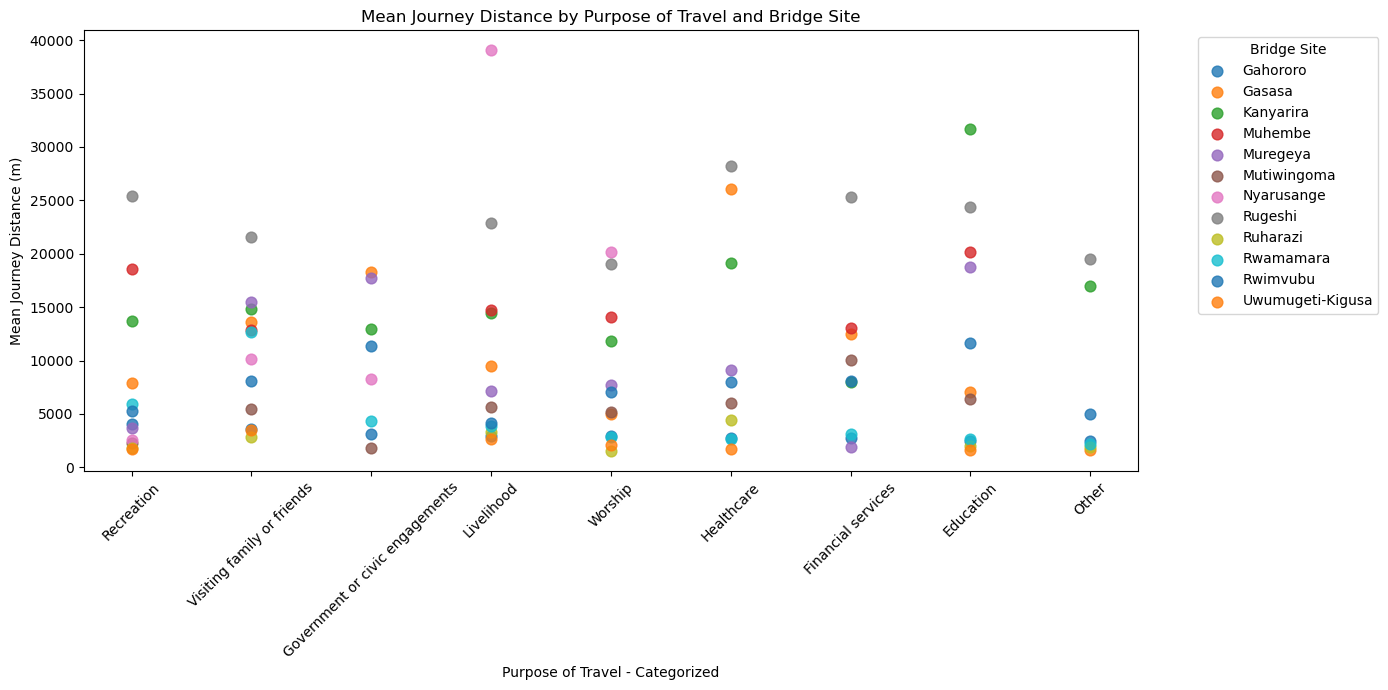

,Bridge Site,Purpose of Travel - Categorized,total_distance
6,Gahororo,Recreation,4022.982394
7,Gahororo,Visiting family or friends,3595.732923
2,Gahororo,Government or civic engagements,3163.885041
4,Gahororo,Livelihood,2961.638848
8,Gahororo,Worship,2943.651784
...,...,...,...
95,Uwumugeti-Kigusa,Healthcare,1727.705949
98,Uwumugeti-Kigusa,Recreation,1683.886253
93,Uwumugeti-Kigusa,Education,1629.760935
94,Uwumugeti-Kigusa,Financial services,NaN


In [115]:
def calculate_mean_distance_by_purpose_and_bridge(survey_data):
    # Group by Bridge Site and Purpose of Travel - Categorized, then calculate mean
    mean_distance = (
        survey_data
        .groupby(['Bridge Site', 'Purpose of Travel - Categorized'])['total_distance']
        .mean()
        .reset_index()
        .sort_values(['Bridge Site', 'total_distance'], ascending=[True, False])
    )

    # Scatterplot: X = Purpose of Travel, Y = Mean Journey Distance, color = Bridge Site
    plt.figure(figsize=(14, 7))
    categories = mean_distance['Purpose of Travel - Categorized'].dropna().unique()
    category_map = {cat: idx for idx, cat in enumerate(categories)}
    bridges = mean_distance['Bridge Site'].unique()
    for bridge in bridges:
        subset = mean_distance[mean_distance['Bridge Site'] == bridge]
        x = subset['Purpose of Travel - Categorized'].map(category_map)
        plt.scatter(
            x,
            subset['total_distance'],
            label=bridge,
            alpha=0.8,
            s=60
        )
    plt.title("Mean Journey Distance by Purpose of Travel and Bridge Site")
    plt.xlabel("Purpose of Travel - Categorized")
    plt.ylabel("Mean Journey Distance (m)")
    plt.xticks(ticks=range(len(categories)), labels=categories, rotation=45)
    plt.legend(title="Bridge Site", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return mean_distance

# Apply the function
calculate_mean_distance_by_purpose_and_bridge(Rwanda_catchment_surveys)